In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
data = pd.read_csv('data/custom_train_2.csv')

In [3]:
class_label = data['class'].unique()
class_label

array(['협박 대화', '기타 괴롭힘 대화', '갈취 대화', '직장 내 괴롭힘 대화', '일반 대화'],
      dtype=object)

In [4]:
from sklearn.preprocessing import LabelEncoder
y = data['label']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [5]:
data.head()

,idx,class,conversation,label
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...,0
1,0,협박 대화,. 죄송합니다 . 정말 잘못했습니다 . 너에게는 선택권이 없어 . 선택 못한다면 너...,0
2,1,협박 대화,길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...,0
3,1,협박 대화,. 장난전화는 업무방해죄에 해당됩니다 . 판단은 너에게 달려있다 . 길동경찰서에도...,0
4,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...,3


In [6]:
X_list = list(np.stack(data['conversation'].values))


In [7]:
X_list[6436]

'정 과장님 왜 ? 다름이 아니라 저 부모님이 아프신데 간호 할 사람이 저밖에 없어서 휴가를 써야 할 것 같습니다 . 부모님이 아프시면 간병인을 쓰면 되지 않나 . 그래서 자식이 옆에 있어야 조금이라도 도움이 될 것 같아서 그렇습니다 . 안돼 . 내가 누누이 경고했지 집안일을'

## KoBert

In [8]:
# https://github.com/SKTBrain/KoBERT/tree/master/kobert_hf

# ! pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [9]:
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [10]:
sample = tokenizer.encode(X_list[0])

In [11]:
tokenizer.decode(sample)

'[CLS] 지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게. 정말 잘못했습니다. 너가 선택해. 너가 죽을래 네 가족을 죽여줄까[SEP]'

In [12]:
total_data_text = list(X_list)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이 평균, 최대, 표준편차
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2.5*표준편차)
max_tokens = np.mean(num_tokens) + 0 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {100 * np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함. ')

문장길이 평균 :  143.6829292929293
문장길이 최대 :  455
문장길이 표준편차 :  70.74681112494424
pad_sequences maxlen :  143
전체 문장의 60.81818181818182%가 maxlen 설정값 이내에 포함. 


In [13]:
inputs = tokenizer(X_list,return_tensors='tf', 
                   padding=True, truncation=True,max_length=maxlen)


In [14]:
X = tf.multiply(inputs.input_ids,inputs.attention_mask)

In [15]:
X.numpy()

array([[   2, 4299, 1457, ...,    0,    0,    0],
       [   2,  517,   54, ...,    0,    0,    0],
       [   2, 1315, 5872, ...,    0,    0,    0],
       ...,
       [   2,  517, 5330, ..., 4955, 6970,    3],
       [   2, 3097, 3511, ..., 5770, 1406,    3],
       [   2, 1375, 1194, ...,    0,    0,    0]], dtype=int32)

### 데이터 분할

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y, test_size=0.1, random_state=42)


In [17]:
y_train

array([4, 1, 1, ..., 3, 3, 1])

In [18]:
X_train

array([[   2, 3480, 6536, ...,    0,    0,    0],
       [   2,  537, 7020, ...,    0,    0,    0],
       [   2, 3257, 5330, ...,  905, 7266,    3],
       ...,
       [   2, 1457, 5702, ..., 1698, 3493,    3],
       [   2, 1457, 5025, ...,    0,    0,    0],
       [   2, 1316, 7960, ...,    0,    0,    0]], dtype=int32)

## 모델

In [19]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()   # 부모 클래스 상속 초기화, 필수는 아님 
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            # tf.newaxis : 차원 추가, [:, tf.newaxis]은 열벡터로 변환 
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],  
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        # 차원 추가 (1, ...)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
    
    def get_config(self):
        return {
            'position': self.pos_encoding.shape[1],
            'd_model': self.pos_encoding.shape[2],
        }

In [20]:
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    # tf.shape(key)[-1] = 워드벡터의 크기 
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    # 마스크의 1이면 큰값을 빼는 거니까 softmax를 지나면 0에 수렴 
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        # 워드벡터가 헤드수로 나머지 없이 나누어 져야함
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        # input.shape : [batch_size, seq_len, d_model(self.num_head*self.depth)]
            # seq_len : 문장길이
            # d_model : 임베딩 차원 
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        #[batch_size, self.num_head, seq_len, self.depth)]
        # transpose를 통해 num_heads를 앞으로 불러와 병렬연산 효율성(gpu활용성)을 높임 
            # 일반적으로 뒷 차원의 크기가 클 수록 효율적
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query,batch_size)
        key = self.split_heads(key,batch_size)
        value = self.split_heads(value,batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

    def get_config(self):
        return {
            'num_heads': self.num_heads,
            'd_model': self.d_model,
            'depth': self.depth,
        }

In [22]:
# 숫자가 0인 부분을 체크한 벡터를 리턴
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [23]:
# 숫자가 0인 부분도 마스킹
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    # tf.linalg.band_part: 대각요소를 가져오거나 이를 기준을 다른 것을 제거 
        # (텐서, 유지할 아래 대각요소, 유지할 위 대각요소) -1이면 전부 
        # 대각요소는 항상 유지 
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [24]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [25]:
# 전체 인코더. 인코딩 레이어를 여러개 
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,),name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [26]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                num_classes,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
  
    # 인코더에서 패딩을 위한 마스크
    # output_shape:mask[:, tf.newaxis, tf.newaxis, :]를 (1,1,batch_size,sequence_length)로 변경
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), 
        name='enc_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model, 
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.GlobalAveragePooling1D()(enc_outputs)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(outputs)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)


In [27]:
# ! pip install wandb==0.16.0

In [28]:
import wandb

In [29]:
wandb.login(key = 'a37365b93b89624b1f639438fcc3d6c5503f21b5')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [35]:
# 하이퍼파라미터
# NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수 
# D_MODEL = 64 # 인코더와 디코더 내부의 입/출력의 고정 차원
# UNITS = 128 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

NUM_HEADS = 4 # 멀티 헤드 어텐션에서의 헤드 수 
NUM_CLASSES = len(class_label)  #레이블 수
VOCAB_SIZE = tokenizer.vocab_size #단어사전 크기
MAX_LENGTH = X.shape[1] # maxlen


In [31]:
sweep_config = {
    "name": "sweep_test_nlp",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        # 피드 포워드 신경망의 은닉층의 크기
        "UNITS" : {"values" : [32, 64, 128]}, 
        # 인코더 층의 개수
        "NUM_LAYERS" : {
            "distribution": "int_uniform",
            "min" : 3,
            "max" : 6
        },
        # 인코더 입/출력의 차원
        "D_MODEL" :{"values" : [32, 64, 128]}          
        }
    }

In [32]:
def train():
    default_config = {
        "VOCAB_SIZE" : VOCAB_SIZE,
        "UNITS" : 128,
        "NUM_CLASSES" : 5,
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 30,
        "batch_size" : 32,
        "NUM_LAYERS" : 4,
        "D_MODEL" : 128,
        "NUM_HEADS" : 4  
    }
    import os

    # 환경 변수 설정
    os.environ['WANDB_AGENT_DISABLE_FLAPPING'] = 'true'

    wandb.init(config = default_config)
    
    config = wandb.config
    
    model = transformer(
        vocab_size=config.VOCAB_SIZE,
        num_layers=config.NUM_LAYERS,
        units=config.UNITS,
        d_model=config.D_MODEL,
        num_heads=config.NUM_HEADS,
        num_classes=config.NUM_CLASSES,
        dropout=0.1)

    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.

    # Optimizer 설정 
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
                                                       
    model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)

    # WandbCallback 함수는 후술합니다.    
    EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
    from wandb.keras import WandbCallback

    model.fit(X_train, y_train,
              epochs = config.epoch,
              batch_size = config.batch_size,
              validation_split=0.2,
              callbacks = [EarlyStopping, WandbCallback()])
    
    
    validation_loss, validation_accuracy = model.evaluate(X_test, y_test, verbose=2)
    
    validation_loss_log = validation_loss.numpy() if isinstance(validation_loss, tf.Tensor) else validation_loss
    validation_accuracy_log = validation_accuracy.numpy() if isinstance(validation_accuracy, tf.Tensor) else validation_accuracy
  

    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Validation Accuracy Rate: " : round(validation_accuracy_log * 100, 2),
               "Validation Error Rate: " : round((1 - validation_accuracy_log) * 100, 2),
               "Validation Loss" : validation_loss_log
              })


In [33]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = 'silpiria',
                       project = 'DLTHON1')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)

Create sweep with ID: ullwpbz5
Sweep URL: https://wandb.ai/silpiria/DLTHON1/sweeps/ullwpbz5


wandb: Agent Starting Run: 99nu7qay with config:
wandb: 	D_MODEL: 128
wandb: 	NUM_LAYERS: 6
wandb: 	UNITS: 64
wandb: Currently logged in as: silpiria98 (silpiria). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/30
223/223 [==============================] - 17s 48ms/step - loss: 1.2972 - accuracy: 0.4162 - val_loss: 1.2273 - val_accuracy: 0.4287


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 2/30
223/223 [==============================] - 9s 42ms/step - loss: 1.1731 - accuracy: 0.4797 - val_loss: 1.1252 - val_accuracy: 0.4675


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 3/30
223/223 [==============================] - 9s 42ms/step - loss: 1.0405 - accuracy: 0.5664 - val_loss: 0.9294 - val_accuracy: 0.6375


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 4/30
223/223 [==============================] - 9s 42ms/step - loss: 0.8466 - accuracy: 0.6647 - val_loss: 0.8037 - val_accuracy: 0.6773


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 5/30
223/223 [==============================] - 9s 42ms/step - loss: 0.7362 - accuracy: 0.7135 - val_loss: 0.7988 - val_accuracy: 0.6925


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 6/30
223/223 [==============================] - 9s 42ms/step - loss: 0.6608 - accuracy: 0.7457 - val_loss: 0.6842 - val_accuracy: 0.7402


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 7/30
223/223 [==============================] - 9s 42ms/step - loss: 0.5982 - accuracy: 0.7712 - val_loss: 0.6845 - val_accuracy: 0.7464
Epoch 8/30
223/223 [==============================] - 10s 43ms/step - loss: 0.5558 - accuracy: 0.7912 - val_loss: 0.6689 - val_accuracy: 0.7553


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 9/30
223/223 [==============================] - 9s 42ms/step - loss: 0.5157 - accuracy: 0.8103 - val_loss: 0.6422 - val_accuracy: 0.7626


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 10/30
223/223 [==============================] - 9s 42ms/step - loss: 0.4913 - accuracy: 0.8159 - val_loss: 0.5901 - val_accuracy: 0.7772


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 11/30
223/223 [==============================] - 9s 42ms/step - loss: 0.4736 - accuracy: 0.8251 - val_loss: 0.5805 - val_accuracy: 0.7811


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 12/30
223/223 [==============================] - 9s 42ms/step - loss: 0.4340 - accuracy: 0.8392 - val_loss: 0.6889 - val_accuracy: 0.7379
Epoch 13/30
223/223 [==============================] - 9s 42ms/step - loss: 0.4137 - accuracy: 0.8479 - val_loss: 0.6001 - val_accuracy: 0.7744
Epoch 14/30
223/223 [==============================] - 9s 42ms/step - loss: 0.3947 - accuracy: 0.8544 - val_loss: 0.6155 - val_accuracy: 0.7727
31/31 - 1s - loss: 0.6164 - accuracy: 0.7838


Validation Accuracy Rate:,▁
Validation Error Rate:,▁
Validation Loss,▁
accuracy,▁▂▃▅▆▆▇▇▇▇████
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▇▆▅▄▃▃▂▂▂▂▁▁▁
val_accuracy,▁▂▅▆▆▇▇▇███▇██
val_loss,█▇▅▃▃▂▂▂▂▁▁▂▁▁
Validation Accuracy Rate:,78.38
Validation Error Rate:,21.62
Validation Loss,0.61644


wandb: Agent Starting Run: q6lor9ty with config:
wandb: 	D_MODEL: 64
wandb: 	NUM_LAYERS: 6
wandb: 	UNITS: 128


Epoch 1/30
223/223 [==============================] - 15s 41ms/step - loss: 1.5045 - accuracy: 0.3309 - val_loss: 1.2872 - val_accuracy: 0.3996


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 2/30
223/223 [==============================] - 8s 36ms/step - loss: 1.2325 - accuracy: 0.4314 - val_loss: 1.2243 - val_accuracy: 0.4624


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 3/30
223/223 [==============================] - 8s 36ms/step - loss: 1.1748 - accuracy: 0.4652 - val_loss: 1.1400 - val_accuracy: 0.4888


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 4/30
223/223 [==============================] - 8s 36ms/step - loss: 1.0932 - accuracy: 0.5147 - val_loss: 1.0327 - val_accuracy: 0.5376


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 5/30
223/223 [==============================] - 8s 36ms/step - loss: 0.9822 - accuracy: 0.5833 - val_loss: 0.8959 - val_accuracy: 0.6352


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 6/30
223/223 [==============================] - 8s 37ms/step - loss: 0.8918 - accuracy: 0.6251 - val_loss: 0.8529 - val_accuracy: 0.6397


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 7/30
223/223 [==============================] - 8s 36ms/step - loss: 0.8253 - accuracy: 0.6528 - val_loss: 0.8076 - val_accuracy: 0.6762


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 8/30
223/223 [==============================] - 8s 36ms/step - loss: 0.7750 - accuracy: 0.6871 - val_loss: 0.7502 - val_accuracy: 0.6930


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 9/30
223/223 [==============================] - 8s 36ms/step - loss: 0.7276 - accuracy: 0.7069 - val_loss: 0.7535 - val_accuracy: 0.6981
Epoch 10/30
223/223 [==============================] - 8s 35ms/step - loss: 0.6925 - accuracy: 0.7247 - val_loss: 0.6860 - val_accuracy: 0.7284


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 11/30
223/223 [==============================] - 8s 36ms/step - loss: 0.6600 - accuracy: 0.7406 - val_loss: 0.6775 - val_accuracy: 0.7363


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 12/30
223/223 [==============================] - 8s 36ms/step - loss: 0.6266 - accuracy: 0.7590 - val_loss: 0.6612 - val_accuracy: 0.7486


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 13/30
223/223 [==============================] - 8s 36ms/step - loss: 0.6083 - accuracy: 0.7647 - val_loss: 0.6551 - val_accuracy: 0.7508


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 14/30
223/223 [==============================] - 8s 36ms/step - loss: 0.5806 - accuracy: 0.7726 - val_loss: 0.6426 - val_accuracy: 0.7677


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 15/30
223/223 [==============================] - 8s 36ms/step - loss: 0.5601 - accuracy: 0.7837 - val_loss: 0.6125 - val_accuracy: 0.7677


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 16/30
223/223 [==============================] - 8s 36ms/step - loss: 0.5498 - accuracy: 0.7870 - val_loss: 0.6385 - val_accuracy: 0.7660
Epoch 17/30
223/223 [==============================] - 8s 36ms/step - loss: 0.5233 - accuracy: 0.8005 - val_loss: 0.5992 - val_accuracy: 0.7840


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 18/30
223/223 [==============================] - 8s 36ms/step - loss: 0.4987 - accuracy: 0.8121 - val_loss: 0.5906 - val_accuracy: 0.7823


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 19/30
223/223 [==============================] - 8s 36ms/step - loss: 0.4883 - accuracy: 0.8151 - val_loss: 0.5958 - val_accuracy: 0.7806
Epoch 20/30
223/223 [==============================] - 8s 35ms/step - loss: 0.4757 - accuracy: 0.8214 - val_loss: 0.6033 - val_accuracy: 0.7778
Epoch 21/30
223/223 [==============================] - 8s 36ms/step - loss: 0.4674 - accuracy: 0.8238 - val_loss: 0.5706 - val_accuracy: 0.7879


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 22/30
223/223 [==============================] - 8s 37ms/step - loss: 0.4566 - accuracy: 0.8298 - val_loss: 0.5637 - val_accuracy: 0.7856


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 23/30
223/223 [==============================] - 8s 36ms/step - loss: 0.4387 - accuracy: 0.8356 - val_loss: 0.5758 - val_accuracy: 0.7851
Epoch 24/30
223/223 [==============================] - 8s 35ms/step - loss: 0.4157 - accuracy: 0.8441 - val_loss: 0.5683 - val_accuracy: 0.7941
Epoch 25/30
223/223 [==============================] - 8s 35ms/step - loss: 0.4123 - accuracy: 0.8453 - val_loss: 0.5662 - val_accuracy: 0.7941
31/31 - 1s - loss: 0.5171 - accuracy: 0.8253


Validation Accuracy Rate:,▁
Validation Error Rate:,▁
Validation Loss,▁
accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇████████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▅▅▆▆▆▇▇▇▇████████████
val_loss,█▇▇▆▄▄▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
Validation Accuracy Rate:,82.53
Validation Error Rate:,17.47
Validation Loss,0.51711


wandb: Agent Starting Run: iccu8p4y with config:
wandb: 	D_MODEL: 32
wandb: 	NUM_LAYERS: 5
wandb: 	UNITS: 64


Epoch 1/30
223/223 [==============================] - 12s 33ms/step - loss: 1.7112 - accuracy: 0.3134 - val_loss: 1.3903 - val_accuracy: 0.3692


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 2/30
223/223 [==============================] - 6s 29ms/step - loss: 1.3197 - accuracy: 0.4007 - val_loss: 1.2739 - val_accuracy: 0.4012


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 3/30
223/223 [==============================] - 6s 29ms/step - loss: 1.2492 - accuracy: 0.4185 - val_loss: 1.2366 - val_accuracy: 0.4276


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 4/30
223/223 [==============================] - 6s 29ms/step - loss: 1.2173 - accuracy: 0.4335 - val_loss: 1.2281 - val_accuracy: 0.4383


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 5/30
223/223 [==============================] - 6s 29ms/step - loss: 1.1915 - accuracy: 0.4394 - val_loss: 1.1861 - val_accuracy: 0.4781


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 6/30
223/223 [==============================] - 6s 28ms/step - loss: 1.1653 - accuracy: 0.4668 - val_loss: 1.1684 - val_accuracy: 0.4860


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 7/30
223/223 [==============================] - 6s 28ms/step - loss: 1.1374 - accuracy: 0.4822 - val_loss: 1.1424 - val_accuracy: 0.4961


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 8/30
223/223 [==============================] - 6s 29ms/step - loss: 1.1027 - accuracy: 0.5125 - val_loss: 1.1094 - val_accuracy: 0.5112


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 9/30
223/223 [==============================] - 6s 29ms/step - loss: 1.0653 - accuracy: 0.5325 - val_loss: 1.0353 - val_accuracy: 0.5758


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 10/30
223/223 [==============================] - 6s 28ms/step - loss: 1.0239 - accuracy: 0.5636 - val_loss: 0.9958 - val_accuracy: 0.5724


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 11/30
223/223 [==============================] - 6s 29ms/step - loss: 0.9779 - accuracy: 0.5826 - val_loss: 0.9487 - val_accuracy: 0.6218


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 12/30
223/223 [==============================] - 6s 29ms/step - loss: 0.9350 - accuracy: 0.6014 - val_loss: 0.8877 - val_accuracy: 0.6369


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 13/30
223/223 [==============================] - 6s 29ms/step - loss: 0.8909 - accuracy: 0.6319 - val_loss: 0.8677 - val_accuracy: 0.6431


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 14/30
223/223 [==============================] - 6s 28ms/step - loss: 0.8588 - accuracy: 0.6477 - val_loss: 0.8372 - val_accuracy: 0.6515


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 15/30
223/223 [==============================] - 6s 29ms/step - loss: 0.8291 - accuracy: 0.6625 - val_loss: 0.8101 - val_accuracy: 0.6655


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 16/30
223/223 [==============================] - 6s 28ms/step - loss: 0.8066 - accuracy: 0.6668 - val_loss: 0.7762 - val_accuracy: 0.6869


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 17/30
223/223 [==============================] - 6s 29ms/step - loss: 0.7774 - accuracy: 0.6817 - val_loss: 0.7574 - val_accuracy: 0.6930


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 18/30
223/223 [==============================] - 6s 29ms/step - loss: 0.7573 - accuracy: 0.6982 - val_loss: 0.7352 - val_accuracy: 0.7116


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 19/30
223/223 [==============================] - 6s 29ms/step - loss: 0.7343 - accuracy: 0.7048 - val_loss: 0.7572 - val_accuracy: 0.6964
Epoch 20/30
223/223 [==============================] - 6s 28ms/step - loss: 0.7130 - accuracy: 0.7137 - val_loss: 0.7238 - val_accuracy: 0.7088


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 21/30
223/223 [==============================] - 6s 29ms/step - loss: 0.6949 - accuracy: 0.7187 - val_loss: 0.6822 - val_accuracy: 0.7312


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 22/30
223/223 [==============================] - 6s 28ms/step - loss: 0.6756 - accuracy: 0.7340 - val_loss: 0.6820 - val_accuracy: 0.7323


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 23/30
223/223 [==============================] - 6s 29ms/step - loss: 0.6591 - accuracy: 0.7403 - val_loss: 0.6692 - val_accuracy: 0.7368


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 24/30
223/223 [==============================] - 6s 29ms/step - loss: 0.6478 - accuracy: 0.7417 - val_loss: 0.6981 - val_accuracy: 0.7385
Epoch 25/30
223/223 [==============================] - 6s 28ms/step - loss: 0.6404 - accuracy: 0.7471 - val_loss: 0.6894 - val_accuracy: 0.7312
Epoch 26/30
223/223 [==============================] - 6s 28ms/step - loss: 0.6234 - accuracy: 0.7513 - val_loss: 0.6643 - val_accuracy: 0.7430


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 27/30
223/223 [==============================] - 6s 28ms/step - loss: 0.6130 - accuracy: 0.7588 - val_loss: 0.6514 - val_accuracy: 0.7486


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 28/30
223/223 [==============================] - 6s 28ms/step - loss: 0.6067 - accuracy: 0.7608 - val_loss: 0.6496 - val_accuracy: 0.7486


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


Epoch 29/30
223/223 [==============================] - 6s 29ms/step - loss: 0.5943 - accuracy: 0.7682 - val_loss: 0.6501 - val_accuracy: 0.7576
Epoch 30/30
223/223 [==============================] - 6s 28ms/step - loss: 0.5707 - accuracy: 0.7786 - val_loss: 0.6429 - val_accuracy: 0.7553


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_121210-iccu8p4y/files/model-best)... Done. 0.0s


31/31 - 0s - loss: 0.5886 - accuracy: 0.7778


Validation Accuracy Rate:,▁
Validation Error Rate:,▁
Validation Loss,▁
accuracy,▁▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▂▂▂▃▃▃▄▅▅▆▆▆▆▆▇▇▇▇▇██████████
val_loss,█▇▇▆▆▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁
Validation Accuracy Rate:,77.78
Validation Error Rate:,22.22
Validation Loss,0.58862


wandb: Agent Starting Run: u261q6pj with config:
wandb: 	D_MODEL: 64
wandb: 	NUM_LAYERS: 3
wandb: 	UNITS: 32


Epoch 1/30
223/223 [==============================] - 8s 22ms/step - loss: 1.6336 - accuracy: 0.2765 - val_loss: 1.4924 - val_accuracy: 0.3850


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 2/30
223/223 [==============================] - 4s 20ms/step - loss: 1.3932 - accuracy: 0.4301 - val_loss: 1.2950 - val_accuracy: 0.4439


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 3/30
223/223 [==============================] - 4s 19ms/step - loss: 1.2460 - accuracy: 0.4675 - val_loss: 1.2139 - val_accuracy: 0.4820


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 4/30
223/223 [==============================] - 4s 20ms/step - loss: 1.1792 - accuracy: 0.5079 - val_loss: 1.1575 - val_accuracy: 0.5309


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 5/30
223/223 [==============================] - 4s 20ms/step - loss: 1.1216 - accuracy: 0.5586 - val_loss: 1.0968 - val_accuracy: 0.5561


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 6/30
223/223 [==============================] - 4s 20ms/step - loss: 1.0494 - accuracy: 0.6023 - val_loss: 1.0193 - val_accuracy: 0.6016


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 7/30
223/223 [==============================] - 4s 19ms/step - loss: 0.9635 - accuracy: 0.6511 - val_loss: 0.9282 - val_accuracy: 0.6532


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 8/30
223/223 [==============================] - 4s 19ms/step - loss: 0.8778 - accuracy: 0.6863 - val_loss: 0.8532 - val_accuracy: 0.6801


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 9/30
223/223 [==============================] - 4s 19ms/step - loss: 0.7956 - accuracy: 0.7153 - val_loss: 0.7858 - val_accuracy: 0.7071


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 10/30
223/223 [==============================] - 4s 19ms/step - loss: 0.7257 - accuracy: 0.7428 - val_loss: 0.7444 - val_accuracy: 0.7183


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 11/30
223/223 [==============================] - 4s 19ms/step - loss: 0.6713 - accuracy: 0.7577 - val_loss: 0.7045 - val_accuracy: 0.7357


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 12/30
223/223 [==============================] - 4s 19ms/step - loss: 0.6233 - accuracy: 0.7854 - val_loss: 0.6826 - val_accuracy: 0.7458


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 13/30
223/223 [==============================] - 4s 20ms/step - loss: 0.5798 - accuracy: 0.7903 - val_loss: 0.6583 - val_accuracy: 0.7514


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 14/30
223/223 [==============================] - 4s 19ms/step - loss: 0.5588 - accuracy: 0.7992 - val_loss: 0.6360 - val_accuracy: 0.7609


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 15/30
223/223 [==============================] - 4s 20ms/step - loss: 0.5228 - accuracy: 0.8112 - val_loss: 0.6133 - val_accuracy: 0.7682


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 16/30
223/223 [==============================] - 4s 20ms/step - loss: 0.5046 - accuracy: 0.8189 - val_loss: 0.6074 - val_accuracy: 0.7744


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 17/30
223/223 [==============================] - 4s 20ms/step - loss: 0.4797 - accuracy: 0.8252 - val_loss: 0.6111 - val_accuracy: 0.7789
Epoch 18/30
223/223 [==============================] - 4s 19ms/step - loss: 0.4630 - accuracy: 0.8336 - val_loss: 0.5906 - val_accuracy: 0.7817


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 19/30
223/223 [==============================] - 4s 20ms/step - loss: 0.4493 - accuracy: 0.8359 - val_loss: 0.5874 - val_accuracy: 0.7823


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 20/30
223/223 [==============================] - 4s 19ms/step - loss: 0.4353 - accuracy: 0.8465 - val_loss: 0.5874 - val_accuracy: 0.7941


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 21/30
223/223 [==============================] - 4s 19ms/step - loss: 0.4222 - accuracy: 0.8503 - val_loss: 0.5827 - val_accuracy: 0.7896


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 22/30
223/223 [==============================] - 4s 19ms/step - loss: 0.4037 - accuracy: 0.8583 - val_loss: 0.5728 - val_accuracy: 0.7912


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 23/30
223/223 [==============================] - 4s 19ms/step - loss: 0.3903 - accuracy: 0.8605 - val_loss: 0.5631 - val_accuracy: 0.7991


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 24/30
223/223 [==============================] - 4s 20ms/step - loss: 0.3811 - accuracy: 0.8632 - val_loss: 0.5880 - val_accuracy: 0.7884
Epoch 25/30
223/223 [==============================] - 4s 19ms/step - loss: 0.3690 - accuracy: 0.8684 - val_loss: 0.5587 - val_accuracy: 0.7997


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122251-u261q6pj/files/model-best)... Done. 0.0s


Epoch 26/30
223/223 [==============================] - 4s 19ms/step - loss: 0.3573 - accuracy: 0.8740 - val_loss: 0.5710 - val_accuracy: 0.8030
Epoch 27/30
223/223 [==============================] - 4s 19ms/step - loss: 0.3464 - accuracy: 0.8788 - val_loss: 0.5591 - val_accuracy: 0.8081
Epoch 28/30
223/223 [==============================] - 4s 19ms/step - loss: 0.3402 - accuracy: 0.8831 - val_loss: 0.5650 - val_accuracy: 0.8075
31/31 - 0s - loss: 0.5040 - accuracy: 0.8374


Validation Accuracy Rate:,▁
Validation Error Rate:,▁
Validation Loss,▁
accuracy,▁▃▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇█████████
epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▄▅▅▆▆▇▇▇▇▇▇▇████████████
val_loss,█▇▆▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy Rate:,83.74
Validation Error Rate:,16.26
Validation Loss,0.50398


wandb: Agent Starting Run: gyg4rwpy with config:
wandb: 	D_MODEL: 32
wandb: 	NUM_LAYERS: 6
wandb: 	UNITS: 128


Epoch 1/30
223/223 [==============================] - 15s 39ms/step - loss: 1.3978 - accuracy: 0.3732 - val_loss: 1.2909 - val_accuracy: 0.4186


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 2/30
223/223 [==============================] - 8s 34ms/step - loss: 1.2752 - accuracy: 0.4098 - val_loss: 1.2580 - val_accuracy: 0.4214


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 3/30
223/223 [==============================] - 8s 34ms/step - loss: 1.2445 - accuracy: 0.4272 - val_loss: 1.2503 - val_accuracy: 0.4282


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 4/30
223/223 [==============================] - 7s 33ms/step - loss: 1.2263 - accuracy: 0.4425 - val_loss: 1.2259 - val_accuracy: 0.4495


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 5/30
223/223 [==============================] - 8s 34ms/step - loss: 1.2054 - accuracy: 0.4414 - val_loss: 1.2169 - val_accuracy: 0.4815


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 6/30
223/223 [==============================] - 8s 34ms/step - loss: 1.1825 - accuracy: 0.4672 - val_loss: 1.1689 - val_accuracy: 0.4921


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 7/30
223/223 [==============================] - 7s 33ms/step - loss: 1.1395 - accuracy: 0.4948 - val_loss: 1.1122 - val_accuracy: 0.5269


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 8/30
223/223 [==============================] - 8s 34ms/step - loss: 1.0901 - accuracy: 0.5316 - val_loss: 1.0505 - val_accuracy: 0.5331


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 9/30
223/223 [==============================] - 8s 34ms/step - loss: 1.0354 - accuracy: 0.5537 - val_loss: 0.9786 - val_accuracy: 0.6094


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 10/30
223/223 [==============================] - 7s 33ms/step - loss: 0.9819 - accuracy: 0.5842 - val_loss: 0.9724 - val_accuracy: 0.5819


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 11/30
223/223 [==============================] - 8s 34ms/step - loss: 0.9401 - accuracy: 0.6037 - val_loss: 0.9322 - val_accuracy: 0.5887


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 12/30
223/223 [==============================] - 8s 34ms/step - loss: 0.9006 - accuracy: 0.6331 - val_loss: 0.8900 - val_accuracy: 0.6184


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 13/30
223/223 [==============================] - 7s 33ms/step - loss: 0.8591 - accuracy: 0.6479 - val_loss: 0.8611 - val_accuracy: 0.6336


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 14/30
223/223 [==============================] - 8s 34ms/step - loss: 0.8273 - accuracy: 0.6695 - val_loss: 0.8301 - val_accuracy: 0.6633


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 15/30
223/223 [==============================] - 8s 34ms/step - loss: 0.8021 - accuracy: 0.6709 - val_loss: 0.7886 - val_accuracy: 0.6818


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 16/30
223/223 [==============================] - 8s 35ms/step - loss: 0.7740 - accuracy: 0.6914 - val_loss: 0.7515 - val_accuracy: 0.6998


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 17/30
223/223 [==============================] - 8s 34ms/step - loss: 0.7462 - accuracy: 0.6989 - val_loss: 0.7421 - val_accuracy: 0.7177


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 18/30
223/223 [==============================] - 8s 34ms/step - loss: 0.7207 - accuracy: 0.7162 - val_loss: 0.7596 - val_accuracy: 0.6930
Epoch 19/30
223/223 [==============================] - 8s 34ms/step - loss: 0.7017 - accuracy: 0.7225 - val_loss: 0.7175 - val_accuracy: 0.7059


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 20/30
223/223 [==============================] - 8s 34ms/step - loss: 0.6748 - accuracy: 0.7368 - val_loss: 0.7105 - val_accuracy: 0.7138


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 21/30
223/223 [==============================] - 8s 34ms/step - loss: 0.6621 - accuracy: 0.7327 - val_loss: 0.6732 - val_accuracy: 0.7357


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 22/30
223/223 [==============================] - 8s 34ms/step - loss: 0.6415 - accuracy: 0.7543 - val_loss: 0.6849 - val_accuracy: 0.7144
Epoch 23/30
223/223 [==============================] - 8s 34ms/step - loss: 0.6263 - accuracy: 0.7600 - val_loss: 0.6636 - val_accuracy: 0.7435


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 24/30
223/223 [==============================] - 8s 34ms/step - loss: 0.6195 - accuracy: 0.7581 - val_loss: 0.6520 - val_accuracy: 0.7334


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 25/30
223/223 [==============================] - 8s 34ms/step - loss: 0.5957 - accuracy: 0.7696 - val_loss: 0.6190 - val_accuracy: 0.7615


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 26/30
223/223 [==============================] - 8s 34ms/step - loss: 0.5843 - accuracy: 0.7743 - val_loss: 0.6552 - val_accuracy: 0.7458
Epoch 27/30
223/223 [==============================] - 7s 33ms/step - loss: 0.5695 - accuracy: 0.7771 - val_loss: 0.6103 - val_accuracy: 0.7682


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


Epoch 28/30
223/223 [==============================] - 8s 34ms/step - loss: 0.5582 - accuracy: 0.7844 - val_loss: 0.6383 - val_accuracy: 0.7531
Epoch 29/30
223/223 [==============================] - 7s 33ms/step - loss: 0.5403 - accuracy: 0.7957 - val_loss: 0.6202 - val_accuracy: 0.7570
Epoch 30/30
223/223 [==============================] - 7s 33ms/step - loss: 0.5259 - accuracy: 0.7997 - val_loss: 0.6023 - val_accuracy: 0.7744


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_122912-gyg4rwpy/files/model-best)... Done. 0.0s


31/31 - 1s - loss: 0.5401 - accuracy: 0.8081


Validation Accuracy Rate:,▁
Validation Error Rate:,▁
Validation Loss,▁
accuracy,▁▂▂▂▂▃▃▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇██████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁▁▂▂▂▃▃▅▄▄▅▅▆▆▇▇▆▇▇▇▇▇▇█▇████
val_loss,███▇▇▇▆▆▅▅▄▄▄▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁
Validation Accuracy Rate:,80.81
Validation Error Rate:,19.19
Validation Loss,0.54014


wandb: Agent Starting Run: m51d7pfi with config:
wandb: 	D_MODEL: 64
wandb: 	NUM_LAYERS: 4
wandb: 	UNITS: 128


Epoch 1/30
223/223 [==============================] - 10s 28ms/step - loss: 1.4331 - accuracy: 0.3785 - val_loss: 1.2646 - val_accuracy: 0.4237


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 2/30
223/223 [==============================] - 6s 25ms/step - loss: 1.2458 - accuracy: 0.4318 - val_loss: 1.2182 - val_accuracy: 0.4517


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 3/30
223/223 [==============================] - 6s 25ms/step - loss: 1.1965 - accuracy: 0.4719 - val_loss: 1.1590 - val_accuracy: 0.4618


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 4/30
223/223 [==============================] - 6s 25ms/step - loss: 1.1347 - accuracy: 0.5189 - val_loss: 1.0756 - val_accuracy: 0.5623


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 5/30
223/223 [==============================] - 6s 25ms/step - loss: 1.0408 - accuracy: 0.5741 - val_loss: 0.9585 - val_accuracy: 0.6111


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 6/30
223/223 [==============================] - 6s 25ms/step - loss: 0.9389 - accuracy: 0.6170 - val_loss: 0.8727 - val_accuracy: 0.6397


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 7/30
223/223 [==============================] - 6s 25ms/step - loss: 0.8650 - accuracy: 0.6462 - val_loss: 0.8131 - val_accuracy: 0.6667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 8/30
223/223 [==============================] - 6s 25ms/step - loss: 0.8023 - accuracy: 0.6793 - val_loss: 0.7710 - val_accuracy: 0.6841


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 9/30
223/223 [==============================] - 6s 25ms/step - loss: 0.7556 - accuracy: 0.7058 - val_loss: 0.7281 - val_accuracy: 0.7093


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 10/30
223/223 [==============================] - 6s 25ms/step - loss: 0.6994 - accuracy: 0.7259 - val_loss: 0.6967 - val_accuracy: 0.7284


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 11/30
223/223 [==============================] - 6s 25ms/step - loss: 0.6639 - accuracy: 0.7433 - val_loss: 0.6582 - val_accuracy: 0.7452


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 12/30
223/223 [==============================] - 6s 25ms/step - loss: 0.6298 - accuracy: 0.7572 - val_loss: 0.6327 - val_accuracy: 0.7581


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 13/30
223/223 [==============================] - 6s 25ms/step - loss: 0.5880 - accuracy: 0.7790 - val_loss: 0.6429 - val_accuracy: 0.7514
Epoch 14/30
223/223 [==============================] - 5s 25ms/step - loss: 0.5654 - accuracy: 0.7842 - val_loss: 0.6080 - val_accuracy: 0.7722


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 15/30
223/223 [==============================] - 6s 25ms/step - loss: 0.5447 - accuracy: 0.7921 - val_loss: 0.6332 - val_accuracy: 0.7609
Epoch 16/30
223/223 [==============================] - 5s 24ms/step - loss: 0.5223 - accuracy: 0.8046 - val_loss: 0.5898 - val_accuracy: 0.7789


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 17/30
223/223 [==============================] - 6s 25ms/step - loss: 0.5008 - accuracy: 0.8107 - val_loss: 0.5841 - val_accuracy: 0.7868


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.1s


Epoch 18/30
223/223 [==============================] - 6s 26ms/step - loss: 0.4796 - accuracy: 0.8199 - val_loss: 0.5847 - val_accuracy: 0.7868
Epoch 19/30
223/223 [==============================] - 6s 25ms/step - loss: 0.4704 - accuracy: 0.8260 - val_loss: 0.5698 - val_accuracy: 0.7873


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 20/30
223/223 [==============================] - 5s 25ms/step - loss: 0.4602 - accuracy: 0.8274 - val_loss: 0.5647 - val_accuracy: 0.7873


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 21/30
223/223 [==============================] - 6s 25ms/step - loss: 0.4359 - accuracy: 0.8371 - val_loss: 0.5585 - val_accuracy: 0.7952


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 22/30
223/223 [==============================] - 6s 25ms/step - loss: 0.4221 - accuracy: 0.8436 - val_loss: 0.5533 - val_accuracy: 0.7946


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 23/30
223/223 [==============================] - 6s 25ms/step - loss: 0.4166 - accuracy: 0.8434 - val_loss: 0.5553 - val_accuracy: 0.7980
Epoch 24/30
223/223 [==============================] - 5s 24ms/step - loss: 0.4038 - accuracy: 0.8502 - val_loss: 0.5599 - val_accuracy: 0.8036
Epoch 25/30
223/223 [==============================] - 5s 24ms/step - loss: 0.3976 - accuracy: 0.8541 - val_loss: 0.5503 - val_accuracy: 0.8047


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 26/30
223/223 [==============================] - 6s 25ms/step - loss: 0.3825 - accuracy: 0.8610 - val_loss: 0.5436 - val_accuracy: 0.8036


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 27/30
223/223 [==============================] - 6s 25ms/step - loss: 0.3789 - accuracy: 0.8590 - val_loss: 0.5340 - val_accuracy: 0.8176


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124129-m51d7pfi/files/model-best)... Done. 0.0s


Epoch 28/30
223/223 [==============================] - 6s 25ms/step - loss: 0.3625 - accuracy: 0.8674 - val_loss: 0.5497 - val_accuracy: 0.8030
Epoch 29/30
223/223 [==============================] - 5s 25ms/step - loss: 0.3458 - accuracy: 0.8735 - val_loss: 0.5386 - val_accuracy: 0.8064
Epoch 30/30
223/223 [==============================] - 5s 24ms/step - loss: 0.3322 - accuracy: 0.8813 - val_loss: 0.5371 - val_accuracy: 0.8215
31/31 - 0s - loss: 0.5149 - accuracy: 0.8202


Validation Accuracy Rate:,▁
Validation Error Rate:,▁
Validation Loss,▁
accuracy,▁▂▂▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▆▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
val_loss,██▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy Rate:,82.02
Validation Error Rate:,17.98
Validation Loss,0.51487


wandb: Agent Starting Run: hq8b2yrq with config:
wandb: 	D_MODEL: 64
wandb: 	NUM_LAYERS: 5
wandb: 	UNITS: 128


Epoch 1/30
223/223 [==============================] - 12s 34ms/step - loss: 1.4950 - accuracy: 0.3503 - val_loss: 1.2751 - val_accuracy: 0.4181


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best)... Done. 0.0s


Epoch 2/30
223/223 [==============================] - 7s 31ms/step - loss: 1.2418 - accuracy: 0.4426 - val_loss: 1.2194 - val_accuracy: 0.4394


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best)... Done. 0.0s


Epoch 3/30
223/223 [==============================] - 7s 31ms/step - loss: 1.1825 - accuracy: 0.4767 - val_loss: 1.2019 - val_accuracy: 0.4899


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best)... Done. 0.0s


Epoch 4/30
223/223 [==============================] - 7s 30ms/step - loss: 1.0839 - accuracy: 0.5377 - val_loss: 1.0556 - val_accuracy: 0.5875


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best)... Done. 0.1s


Epoch 5/30
223/223 [==============================] - 7s 30ms/step - loss: 0.9726 - accuracy: 0.5912 - val_loss: 0.9174 - val_accuracy: 0.6077


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best)... Done. 0.0s


Epoch 6/30
223/223 [==============================] - 7s 31ms/step - loss: 0.8938 - accuracy: 0.6348 - val_loss: 0.8694 - val_accuracy: 0.6538


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best)... Done. 0.0s


Epoch 7/30
223/223 [==============================] - 7s 30ms/step - loss: 0.8353 - accuracy: 0.6573 - val_loss: 0.8196 - val_accuracy: 0.6717


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best)... Done. 0.0s


Epoch 8/30
223/223 [==============================] - 7s 30ms/step - loss: 0.7732 - accuracy: 0.6942 - val_loss: 0.7566 - val_accuracy: 0.6958


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best)... Done. 0.1s


Epoch 9/30
223/223 [==============================] - 7s 31ms/step - loss: 0.7190 - accuracy: 0.7138 - val_loss: 0.7919 - val_accuracy: 0.6756
Epoch 10/30
223/223 [==============================] - 7s 30ms/step - loss: 0.6788 - accuracy: 0.7353 - val_loss: 0.7011 - val_accuracy: 0.7245


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best)... Done. 0.0s


Epoch 11/30
223/223 [==============================] - 7s 30ms/step - loss: 0.6497 - accuracy: 0.7483 - val_loss: 0.6905 - val_accuracy: 0.7295


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best)... Done. 0.1s


Epoch 12/30
223/223 [==============================] - 7s 30ms/step - loss: 0.6168 - accuracy: 0.7661 - val_loss: 0.7497 - val_accuracy: 0.7211
Epoch 13/30
223/223 [==============================] - 7s 30ms/step - loss: 0.5853 - accuracy: 0.7776 - val_loss: 0.6779 - val_accuracy: 0.7407


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best)... Done. 0.0s


Epoch 14/30
223/223 [==============================] - 7s 31ms/step - loss: 0.5639 - accuracy: 0.7818 - val_loss: 0.6668 - val_accuracy: 0.7475


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best)... Done. 0.0s


Epoch 15/30
223/223 [==============================] - 7s 30ms/step - loss: 0.5378 - accuracy: 0.7907 - val_loss: 0.6710 - val_accuracy: 0.7548
Epoch 16/30
223/223 [==============================] - 7s 30ms/step - loss: 0.5212 - accuracy: 0.8051 - val_loss: 0.6725 - val_accuracy: 0.7559
Epoch 17/30
223/223 [==============================] - 7s 30ms/step - loss: 0.5007 - accuracy: 0.8105 - val_loss: 0.6222 - val_accuracy: 0.7722


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best)... Done. 0.0s


Epoch 18/30
223/223 [==============================] - 7s 31ms/step - loss: 0.4771 - accuracy: 0.8164 - val_loss: 0.6359 - val_accuracy: 0.7722
Epoch 19/30
223/223 [==============================] - 7s 30ms/step - loss: 0.4696 - accuracy: 0.8263 - val_loss: 0.5923 - val_accuracy: 0.7795


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_124932-hq8b2yrq/files/model-best)... Done. 0.0s


Epoch 20/30
223/223 [==============================] - 7s 31ms/step - loss: 0.4573 - accuracy: 0.8326 - val_loss: 0.6784 - val_accuracy: 0.7727
Epoch 21/30
223/223 [==============================] - 7s 30ms/step - loss: 0.4448 - accuracy: 0.8338 - val_loss: 0.6145 - val_accuracy: 0.7811
Epoch 22/30
223/223 [==============================] - 7s 30ms/step - loss: 0.4314 - accuracy: 0.8410 - val_loss: 0.6469 - val_accuracy: 0.7738
31/31 - 0s - loss: 0.5602 - accuracy: 0.8121


Validation Accuracy Rate:,▁
Validation Error Rate:,▁
Validation Loss,▁
accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇██████
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▂▄▅▆▆▆▆▇▇▇▇▇▇███████
val_loss,█▇▇▆▄▄▃▃▃▂▂▃▂▂▂▂▁▁▁▂▁▂
Validation Accuracy Rate:,81.21
Validation Error Rate:,18.79
Validation Loss,0.5602


wandb: Agent Starting Run: rpftoim8 with config:
wandb: 	D_MODEL: 32
wandb: 	NUM_LAYERS: 6
wandb: 	UNITS: 128


Epoch 1/30
223/223 [==============================] - 15s 39ms/step - loss: 1.5249 - accuracy: 0.3350 - val_loss: 1.3010 - val_accuracy: 0.4080


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 2/30
223/223 [==============================] - 8s 35ms/step - loss: 1.2710 - accuracy: 0.4164 - val_loss: 1.2453 - val_accuracy: 0.4153


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 3/30
223/223 [==============================] - 8s 34ms/step - loss: 1.2375 - accuracy: 0.4262 - val_loss: 1.2344 - val_accuracy: 0.4265


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 4/30
223/223 [==============================] - 7s 33ms/step - loss: 1.2208 - accuracy: 0.4320 - val_loss: 1.2115 - val_accuracy: 0.4226


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 5/30
223/223 [==============================] - 8s 34ms/step - loss: 1.1976 - accuracy: 0.4545 - val_loss: 1.1862 - val_accuracy: 0.4411


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 6/30
223/223 [==============================] - 7s 33ms/step - loss: 1.1766 - accuracy: 0.4684 - val_loss: 1.1499 - val_accuracy: 0.4618


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 7/30
223/223 [==============================] - 7s 33ms/step - loss: 1.1416 - accuracy: 0.4938 - val_loss: 1.1154 - val_accuracy: 0.4736


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 8/30
223/223 [==============================] - 8s 34ms/step - loss: 1.0945 - accuracy: 0.5271 - val_loss: 1.0692 - val_accuracy: 0.5236


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 9/30
223/223 [==============================] - 7s 33ms/step - loss: 1.0444 - accuracy: 0.5539 - val_loss: 1.0021 - val_accuracy: 0.5488


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 10/30
223/223 [==============================] - 7s 33ms/step - loss: 0.9912 - accuracy: 0.5822 - val_loss: 0.9221 - val_accuracy: 0.6134


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 11/30
223/223 [==============================] - 8s 34ms/step - loss: 0.9488 - accuracy: 0.6054 - val_loss: 0.9177 - val_accuracy: 0.6038


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 12/30
223/223 [==============================] - 8s 34ms/step - loss: 0.8973 - accuracy: 0.6310 - val_loss: 0.8722 - val_accuracy: 0.6409


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 13/30
223/223 [==============================] - 8s 34ms/step - loss: 0.8720 - accuracy: 0.6448 - val_loss: 0.8443 - val_accuracy: 0.6639


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 14/30
223/223 [==============================] - 8s 34ms/step - loss: 0.8484 - accuracy: 0.6486 - val_loss: 0.8050 - val_accuracy: 0.6751


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 15/30
223/223 [==============================] - 8s 34ms/step - loss: 0.8127 - accuracy: 0.6727 - val_loss: 0.7950 - val_accuracy: 0.6846


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 16/30
223/223 [==============================] - 7s 33ms/step - loss: 0.7778 - accuracy: 0.6857 - val_loss: 0.7676 - val_accuracy: 0.7026


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 17/30
223/223 [==============================] - 7s 33ms/step - loss: 0.7525 - accuracy: 0.6995 - val_loss: 0.7814 - val_accuracy: 0.6914
Epoch 18/30
223/223 [==============================] - 7s 33ms/step - loss: 0.7371 - accuracy: 0.7052 - val_loss: 0.7325 - val_accuracy: 0.7093


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 19/30
223/223 [==============================] - 8s 34ms/step - loss: 0.7113 - accuracy: 0.7177 - val_loss: 0.7133 - val_accuracy: 0.7262


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_125608-rpftoim8/files/model-best)... Done. 0.0s


Epoch 20/30
223/223 [==============================] - 7s 34ms/step - loss: 0.6984 - accuracy: 0.7243 - val_loss: 0.7428 - val_accuracy: 0.7054
Epoch 21/30
223/223 [==============================] - 7s 33ms/step - loss: 0.6772 - accuracy: 0.7347 - val_loss: 0.7728 - val_accuracy: 0.6958
Epoch 22/30
223/223 [==============================] - 7s 33ms/step - loss: 0.6598 - accuracy: 0.7435 - val_loss: 0.7386 - val_accuracy: 0.7110
31/31 - 0s - loss: 0.7147 - accuracy: 0.7343


Validation Accuracy Rate:,▁
Validation Error Rate:,▁
Validation Loss,▁
accuracy,▁▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇▇▇████
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▆▆▆▅▅▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁
val_accuracy,▁▁▁▁▂▂▂▄▄▆▅▆▇▇▇▇▇███▇█
val_loss,█▇▇▇▇▆▆▅▄▃▃▃▃▂▂▂▂▁▁▁▂▁
Validation Accuracy Rate:,73.43
Validation Error Rate:,26.57
Validation Loss,0.7147


wandb: Agent Starting Run: iq2qvuq2 with config:
wandb: 	D_MODEL: 64
wandb: 	NUM_LAYERS: 5
wandb: 	UNITS: 64


Epoch 1/30
223/223 [==============================] - 13s 35ms/step - loss: 1.6377 - accuracy: 0.3185 - val_loss: 1.2848 - val_accuracy: 0.4164


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 2/30
223/223 [==============================] - 7s 31ms/step - loss: 1.2540 - accuracy: 0.4277 - val_loss: 1.2210 - val_accuracy: 0.4568


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 3/30
223/223 [==============================] - 7s 31ms/step - loss: 1.1942 - accuracy: 0.4596 - val_loss: 1.1806 - val_accuracy: 0.4978


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 4/30
223/223 [==============================] - 7s 30ms/step - loss: 1.1456 - accuracy: 0.5073 - val_loss: 1.1064 - val_accuracy: 0.5146


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 5/30
223/223 [==============================] - 7s 31ms/step - loss: 1.0793 - accuracy: 0.5379 - val_loss: 1.0178 - val_accuracy: 0.5629


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 6/30
223/223 [==============================] - 7s 31ms/step - loss: 0.9860 - accuracy: 0.5927 - val_loss: 0.9209 - val_accuracy: 0.6240


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 7/30
223/223 [==============================] - 7s 30ms/step - loss: 0.9055 - accuracy: 0.6303 - val_loss: 0.8658 - val_accuracy: 0.6352


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 8/30
223/223 [==============================] - 7s 30ms/step - loss: 0.8426 - accuracy: 0.6553 - val_loss: 0.8217 - val_accuracy: 0.6605


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 9/30
223/223 [==============================] - 7s 30ms/step - loss: 0.7831 - accuracy: 0.6908 - val_loss: 0.7395 - val_accuracy: 0.7026


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 10/30
223/223 [==============================] - 7s 30ms/step - loss: 0.7350 - accuracy: 0.7045 - val_loss: 0.7011 - val_accuracy: 0.7160


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.1s


Epoch 11/30
223/223 [==============================] - 7s 30ms/step - loss: 0.6841 - accuracy: 0.7332 - val_loss: 0.7285 - val_accuracy: 0.7071
Epoch 12/30
223/223 [==============================] - 7s 30ms/step - loss: 0.6623 - accuracy: 0.7461 - val_loss: 0.6539 - val_accuracy: 0.7391


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 13/30
223/223 [==============================] - 7s 30ms/step - loss: 0.6254 - accuracy: 0.7579 - val_loss: 0.6485 - val_accuracy: 0.7480


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 14/30
223/223 [==============================] - 7s 30ms/step - loss: 0.5919 - accuracy: 0.7743 - val_loss: 0.6287 - val_accuracy: 0.7559


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.1s


Epoch 15/30
223/223 [==============================] - 7s 30ms/step - loss: 0.5717 - accuracy: 0.7840 - val_loss: 0.6124 - val_accuracy: 0.7609


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 16/30
223/223 [==============================] - 7s 30ms/step - loss: 0.5452 - accuracy: 0.7963 - val_loss: 0.5941 - val_accuracy: 0.7722


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 17/30
223/223 [==============================] - 7s 30ms/step - loss: 0.5253 - accuracy: 0.8012 - val_loss: 0.5796 - val_accuracy: 0.7761


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 18/30
223/223 [==============================] - 7s 30ms/step - loss: 0.5109 - accuracy: 0.8126 - val_loss: 0.5821 - val_accuracy: 0.7783
Epoch 19/30
223/223 [==============================] - 7s 30ms/step - loss: 0.4937 - accuracy: 0.8180 - val_loss: 0.5869 - val_accuracy: 0.7800
Epoch 20/30
223/223 [==============================] - 7s 30ms/step - loss: 0.4811 - accuracy: 0.8187 - val_loss: 0.5440 - val_accuracy: 0.7929


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 21/30
223/223 [==============================] - 7s 30ms/step - loss: 0.4613 - accuracy: 0.8321 - val_loss: 0.5406 - val_accuracy: 0.7941


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 22/30
223/223 [==============================] - 7s 30ms/step - loss: 0.4462 - accuracy: 0.8366 - val_loss: 0.5442 - val_accuracy: 0.8019
Epoch 23/30
223/223 [==============================] - 7s 30ms/step - loss: 0.4301 - accuracy: 0.8434 - val_loss: 0.5371 - val_accuracy: 0.8025


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 24/30
223/223 [==============================] - 7s 30ms/step - loss: 0.4149 - accuracy: 0.8460 - val_loss: 0.5215 - val_accuracy: 0.8086


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 25/30
223/223 [==============================] - 7s 30ms/step - loss: 0.4030 - accuracy: 0.8523 - val_loss: 0.5517 - val_accuracy: 0.7946
Epoch 26/30
223/223 [==============================] - 7s 30ms/step - loss: 0.3959 - accuracy: 0.8590 - val_loss: 0.5289 - val_accuracy: 0.8086
Epoch 27/30
223/223 [==============================] - 7s 30ms/step - loss: 0.3940 - accuracy: 0.8547 - val_loss: 0.5134 - val_accuracy: 0.8086


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 28/30
223/223 [==============================] - 7s 30ms/step - loss: 0.3813 - accuracy: 0.8617 - val_loss: 0.5185 - val_accuracy: 0.8159
Epoch 29/30
223/223 [==============================] - 7s 30ms/step - loss: 0.3599 - accuracy: 0.8690 - val_loss: 0.5112 - val_accuracy: 0.8165


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_130506-iq2qvuq2/files/model-best)... Done. 0.0s


Epoch 30/30
223/223 [==============================] - 7s 30ms/step - loss: 0.3666 - accuracy: 0.8669 - val_loss: 0.5242 - val_accuracy: 0.8103
31/31 - 1s - loss: 0.5223 - accuracy: 0.8172


Validation Accuracy Rate:,▁
Validation Error Rate:,▁
Validation Loss,▁
accuracy,▁▂▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇███████████
val_loss,█▇▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy Rate:,81.72
Validation Error Rate:,18.28
Validation Loss,0.52232


wandb: Agent Starting Run: a3mot7dz with config:
wandb: 	D_MODEL: 128
wandb: 	NUM_LAYERS: 4
wandb: 	UNITS: 64


Epoch 1/30
223/223 [==============================] - 11s 33ms/step - loss: 1.3656 - accuracy: 0.3932 - val_loss: 1.2506 - val_accuracy: 0.4186


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best)... Done. 0.1s


Epoch 2/30
223/223 [==============================] - 7s 30ms/step - loss: 1.2041 - accuracy: 0.4635 - val_loss: 1.1775 - val_accuracy: 0.4618


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best)... Done. 0.1s


Epoch 3/30
223/223 [==============================] - 7s 30ms/step - loss: 1.1129 - accuracy: 0.5429 - val_loss: 1.0473 - val_accuracy: 0.5752


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best)... Done. 0.1s


Epoch 4/30
223/223 [==============================] - 7s 30ms/step - loss: 0.9563 - accuracy: 0.6333 - val_loss: 0.8854 - val_accuracy: 0.6470


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best)... Done. 0.1s


Epoch 5/30
223/223 [==============================] - 7s 30ms/step - loss: 0.7901 - accuracy: 0.7001 - val_loss: 0.7655 - val_accuracy: 0.6947


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best)... Done. 0.1s


Epoch 6/30
223/223 [==============================] - 7s 30ms/step - loss: 0.6701 - accuracy: 0.7507 - val_loss: 0.7597 - val_accuracy: 0.7104


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best)... Done. 0.1s


Epoch 7/30
223/223 [==============================] - 7s 29ms/step - loss: 0.6025 - accuracy: 0.7758 - val_loss: 0.6461 - val_accuracy: 0.7452


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best)... Done. 0.1s


Epoch 8/30
223/223 [==============================] - 7s 30ms/step - loss: 0.5420 - accuracy: 0.7929 - val_loss: 0.6238 - val_accuracy: 0.7570


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best)... Done. 0.1s


Epoch 9/30
223/223 [==============================] - 7s 30ms/step - loss: 0.5074 - accuracy: 0.8151 - val_loss: 0.5921 - val_accuracy: 0.7778


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_131545-a3mot7dz/files/model-best)... Done. 0.1s


Epoch 10/30
223/223 [==============================] - 7s 30ms/step - loss: 0.4798 - accuracy: 0.8214 - val_loss: 0.5986 - val_accuracy: 0.7834
Epoch 11/30
223/223 [==============================] - 7s 29ms/step - loss: 0.4430 - accuracy: 0.8392 - val_loss: 0.6104 - val_accuracy: 0.7789
Epoch 12/30
223/223 [==============================] - 7s 29ms/step - loss: 0.4172 - accuracy: 0.8492 - val_loss: 0.6018 - val_accuracy: 0.7907
31/31 - 0s - loss: 0.5548 - accuracy: 0.8162


Validation Accuracy Rate:,▁
Validation Error Rate:,▁
Validation Loss,▁
accuracy,▁▂▃▅▆▆▇▇▇███
epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▇▆▅▄▃▂▂▂▁▁▁
val_accuracy,▁▂▄▅▆▆▇▇████
val_loss,█▇▆▄▃▃▂▁▁▁▁▁
Validation Accuracy Rate:,81.62
Validation Error Rate:,18.38
Validation Loss,0.55475


In [64]:
model = transformer(
            vocab_size=VOCAB_SIZE,
            num_layers=5,
            units=64,
            d_model=64,
            num_heads=NUM_HEADS,
            num_classes=NUM_CLASSES,
            dropout=DROPOUT)

In [37]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 64)     638208      inputs[0][0]                     
                                                                 enc_padding_mask[0][0]           
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 64)           0           encoder[0][0]          

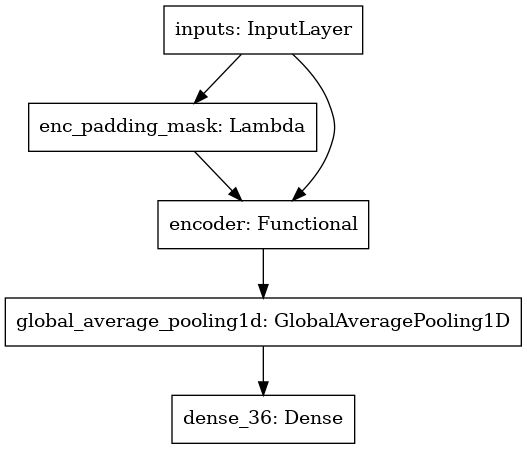

In [35]:
from tensorflow.keras.utils import plot_model
plot_model(model)

F1 score

In [38]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    # 예측값을 0과 1로 반올림
    y_pred = tf.round(y_pred)

    # True Positives, False Positives, False Negatives 계산
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    # Precision, Recall 계산
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # F1 Score 계산
    f1_val = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1_val

In [102]:
epochs=50
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', metrics=['accuracy', f1_score])

In [103]:
from tensorflow.keras.callbacks import  ModelCheckpoint

cb = ModelCheckpoint(f'models/transformer_fin.h5',
                    save_weights_only=True, 
                    save_best_only=False,    
                    monitor='val_loss',
                    mode='min',
                    verbose=1)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[EarlyStopping, cb],
                    verbose=1)

Epoch 1/50
112/112 [==============================] - 11s 52ms/step - loss: 0.0041 - accuracy: 0.9996 - f1_score: 0.9003 - val_loss: 0.1237 - val_accuracy: 0.9686 - val_f1_score: 0.8907

Epoch 00001: saving model to models/transformer_fin.h5
Epoch 2/50
112/112 [==============================] - 5s 43ms/step - loss: 0.0055 - accuracy: 0.9985 - f1_score: 0.9009 - val_loss: 0.1234 - val_accuracy: 0.9680 - val_f1_score: 0.8910

Epoch 00002: saving model to models/transformer_fin.h5
Epoch 3/50
112/112 [==============================] - 5s 44ms/step - loss: 0.0055 - accuracy: 0.9986 - f1_score: 0.9006 - val_loss: 0.1231 - val_accuracy: 0.9680 - val_f1_score: 0.8910

Epoch 00003: saving model to models/transformer_fin.h5
Epoch 4/50
112/112 [==============================] - 5s 44ms/step - loss: 0.0062 - accuracy: 0.9985 - f1_score: 0.9005 - val_loss: 0.1229 - val_accuracy: 0.9680 - val_f1_score: 0.8910

Epoch 00004: saving model to models/transformer_fin.h5
Epoch 5/50
112/112 [===============

**결과 기록**  


In [33]:
# model.save_weights('models/transformer_weights.h5')

In [42]:
# model.load_weights('models/transformer_weights.h5')


In [86]:
# 혼동행렬
y_pred = model.predict(X_test,batch_size=1)
y_pred_classes = np.argmax(y_pred, axis=1)

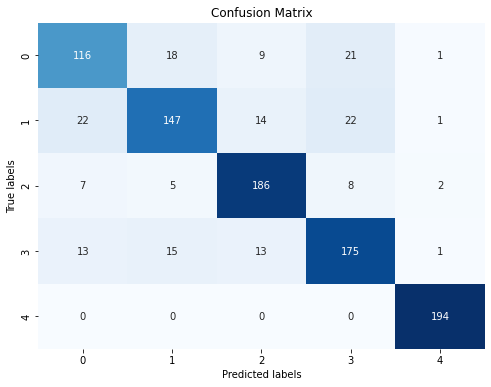

In [87]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_classes)
# 히트맵 그리기

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# test submit

In [88]:
test = pd.read_csv('data/custom_test.csv')

In [89]:
test['conversation'][29]

'선생님도 환자타는 징크스 있겠네요 난 그런거 없어 특이하네요 다들 하나씩 있으시던데 굳이 있다면 족보에도 나와있는 전통적인 징크스 그정도 그게 뭔데요 후배가 산 과자나 음식을 하나라도 먹는다면 어떻게 되는데요 하늘에서 환자가 우수수수수 내려 아 큰일났다 왜왜 내가 지금 먹는 아이스크림 누가 산거야 제 제가 빨리 계좌번호 불러 빨리 돈 보내줄게'

In [90]:
import re
def preprocess_sentence(sentence, stopwords=None):
    # 개행자 삭제
    sentence = re.sub(r'[\n\r]', ' ', sentence)
    
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다. 
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z,가-힣,0-9, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Z가-힣0-9\.\?\!,]", " ", sentence)
    sentence = sentence.strip()

    # '키키'와 같이 연속된 키를 제거합니다.
    sentence = re.sub(r'키{2,}', '', sentence)
    sentence = re.sub(r'\b키\b', '', sentence)

    if stopwords:
        words = sentence.split()
        filtered_words = [word for word in words if word not in stopwords]
        sentence = ' '.join(filtered_words)

    return sentence

In [91]:
test_X = test['conversation'].apply(preprocess_sentence)
test_X_list = list(np.stack(test_X.values))


In [92]:
inputs_test = tokenizer(test_X_list,return_tensors='tf', 
                   padding=True, truncation=True,max_length=maxlen)

In [94]:
test_X = tf.multiply(inputs_test.input_ids,inputs_test.attention_mask)

In [104]:
pred = model.predict(test_X, batch_size=64)

In [101]:
np.save('transformer_predictions.npy', pred)

In [105]:
predicted_classes = np.argmax(pred, axis=1)


서브미션 파일

In [106]:
sub = pd.read_csv("data/new_submission.csv")

In [107]:
sub['class']=predicted_classes

In [108]:
sub.to_csv('data/sub4.csv')

In [109]:
sub['class'].value_counts()

2    124
1    116
0    114
3     99
4     47
Name: class, dtype: int64